# Kubelka-Munk Model

## Introduction
The Kubelka-Munk theory, developed by Paul Kubelka and Franz Munk, is one of the most successful models of mixing paint. Unlike RGB, RYB, Subtractive, and Subtractive-Additive models, the K-M model follows the actual mixing process of paints that occur in real life. Within the paint, incident light and pigment particles interact by having the particles absorb and scatter the light depending on the wavelength. Ultimately, the difference in these absorption and scattering coefficients cause different paints to have different colors. 

The K-M model implemented in this Jupyter Python 3 notebook requires prior knowledge of the absorption and scattering coefficients $K(\lambda)$ and $S(\lambda)$. Provided with user input on the color names and the concentrations of the pigments, the XYZ tristimulus values for this mixture can be calculated.

An overview of the program is included below:

### Format Data [(jump)](#section_1)


Databases including pigment k and s values, xyz CMFs, and D65 illuminant data were formatted and used.

### User Input [(jump)](#section_2)


User input is collected for each paint color name and concentration out of 1.

### Calculate the XYZ Tristimulus Values [(jump)](#section_3)


The XYZ tristimulus values are calculated using Saunderson's equation and the $D_{65}$ illuminant. The equations used in this section are referenced from __[section 2 of this paper](https://scrtwpns.com/mixbox.pdf)__.

### Calculate RGB Values [(jump)](#section_4)


The XYZ tristimulus values are converted to RGB values. The equations used in this section are also referenced from __[section 2 of this paper](https://scrtwpns.com/mixbox.pdf)__.

### Output [(jump)](#section_5)


The RGB values calculated are displayed here.

<a id='section_1'></a>
## Format Data

The first step is to format all of the data used. Specifically, databases including pigment k and s values, xyz CMFs, and illuminant data were used.

Pigment data were referenced from an RIT database created by __[Yoshio Okumura at the Doshisha University](https://scholarworks.rit.edu/cgi/viewcontent.cgi?article=5896&context=theses)__ and described absorption and scattering coefficients of various GOLDEN Heavy Body Acrylics in different wavelengths.

The 2-degree xyz CMFs were obtained from the __[Color & Vision Research Laboratory at UCL](http://cvrl.ioo.ucl.ac.uk/ciexyzpr.htm)__. These CMFs were transformed from the CIE (2006) 2-degree LMS cone fundamentals.

The illuminant data were referenced from the __[CIE standard illuminant D65](https://sources.debian.org/src/colord/1.4.3-4/data/illuminant/CIE-D65.csv/)__ to represent average daylight. 

In [1]:
import pandas as pd
# read data from three files for pigment k and s coefficients, xyz CMFs, 
# and D65 standard illuminant information.
# Information is returned in the form of three dictionaries.
def readData():
    # read files -> DataFrame object
    pigment_data = pd.read_excel("k_and_s_Yoshi_data.xlsx")
    xyz_data = pd.read_csv("XYZ_CMFs.csv")
    D65_data = pd.read_excel("D65.xlsx")

    # convert to dictionary
    pigment_Dict = pigment_data.to_dict()
    xyz_Dict = xyz_data.to_dict('index')
    D65_Dict = D65_data.to_dict('index')

    min_wavelength = xyz_Dict[0]['wavelength']
    max_wavelength = xyz_Dict[len(xyz_Dict)-1]['wavelength']
    return pigment_Dict, xyz_Dict, D65_Dict

pigment_Dict, xyz_Dict, D65_Dict = readData()

<a id='section_2'></a>
## User Input 


After converting the data to dictionaries for easy reference, user input is obtained for the color palette and paint concentrations. It is assumed that the concentration for each paint color ranges from 0 to 1 and that all paint concentrations should add up to equal 1.

In [2]:
# get user input for the names and concentrations of different pigments being mixed. 
import ipywidgets as widgets

def makeFloatSlider(name):
    slider = widgets.FloatSlider(value=0, min=0, max=1.0, step=0.01, description=name, disabled=False,
    continuous_update=True, readout=True, style = {'description_width': '200px'}, layout=widgets.Layout(width='75%'))
    return slider

color_palette = {}
listChoices = ['White', 'Black', 'Cobalt Blue', 'Quinacridone Magenta', 'Phthalo Blue (Green Shade)', 'Hansa Yellow', 'Phthalo Green', 'Pyrrole Red', 'Ultramarine Blue', 'Dioxazine Purple', 'Pyrrole Orange']
listFloatSliders = [makeFloatSlider(choice) for choice in listChoices]

# when button is clicked, add all non-zero concentrations and paint names to color_palette
def on_button_clicked(b):
    color_palette.clear()
    for check in range(len(listChoices)):
        if(listFloatSliders[check].value > 0):
            color_palette.update({listChoices[check]: listFloatSliders[check].value})
    print("Your color palette:", color_palette)

def getUserInput():
    print("Color choices: ")
    display(widgets.VBox(listFloatSliders))
    button = widgets.Button(description = "Done")
    button.on_click(on_button_clicked)
    display(button)

getUserInput()

Color choices: 


Button(description='Done', style=ButtonStyle())

Your color palette: {'White': 0.5, 'Cobalt Blue': 0.5}


<a id='section_3'></a>
## Calculate the XYZ Tristimulus Values

The bulk of the code occurs below. With information about the concentrations of pigments, the XYZ tristimulus values can be calculated.

For each wavelength, these values are calculated:
1. The absorption(k) and scattering(s) of the paint mixture is detemined by a linear combination of the original paints k and s values. 
2. The K-M equations are then used to predict the reflectance spectrum (R_mix) of the mixture. A variable is created for the ks_ratio, which is simply K_mix/S_mix.
3. The Saunderson equation is then used to calculate a modified reflectance spectrum (r_mix_saunders). This modified value accounts for surface reflection and uses measured reflectance constants (k1 and k2). In this project, k1 = 0.092 and k2 = 0.060.
4. To get the CIE standard observer functions (integrands) required to calculate the XYZ tristimulus values, the mixture's xyz values are illuminated with the D65 illuminant in the equations: $\bar{x}\times D65\times r_{mix}$, $\bar{y}\times D65\times r_{mix}$ and $\bar{z}\times D65\times r_{mix}$
5. Finally, these values were integrated over the visible range of wavelengths. Limited by the databases, the wavelength limits were changed to $\lambda \in [390, 730]$

In [3]:
from math import sqrt 
from scipy import integrate
import numpy as np

# integrands to integrate over
x_integrand = []
y_integrand = []
z_integrand = []
Y_D65_integrand = []

limits = range(390, 740, 10)
# for each lambda, calculate the integrands for the K-M model
for wavelength in range(390, 740, 10):
    
    index = int(wavelength%390/10)
    
    # calculate k_mix(lambda) and s_mix(lambda)
    k_mix = 0 # absorption coefficient
    s_mix = 0 # scattering coefficient
    for color in color_palette:
        #if color in pigment_Dict:
        k_mix += (pigment_Dict.get("k " + color)[index] * color_palette.get(color))
        s_mix += (pigment_Dict.get("s " + color)[index] * color_palette.get(color))
        #else:
            #print(color, "not found.")
    
    # reference D65(lambda)
    # convert from increments of 5 to increments of 10 by taking the average
    D65 = (D65_Dict[index*2+19]['D65'] + D65_Dict[index*2+17]['D65'])/2
    
    # calculate R_mix
    ks_ratio = k_mix/s_mix
    r_mix = 1 + ks_ratio - sqrt((ks_ratio)**2+2*ks_ratio)
    
    # calculate R'mix(c, lambda)
    k1 = 0.092 # measured reflectance constants
    k2 = 0.060

    r_mix_saunders = (1-k1)*(1-k2)*r_mix/(1-k2*r_mix)
    
    if(index == 0):
        _x = xyz_Dict[index*2]['x']
        _y = xyz_Dict[index*2]['y']
        _z = xyz_Dict[index*2]['z']
    else: 
        # convert from increments of 5 to increments of 10 by taking the average
        _x = (xyz_Dict[index*2+1]['x'] + xyz_Dict[index*2-1]['x'])/2
        _y = (xyz_Dict[index*2+1]['y'] + xyz_Dict[index*2-1]['y'])/2
        _z = (xyz_Dict[index*2+1]['z'] + xyz_Dict[index*2-1]['z'])/2
    
    # calculate _x(lambda), _y(lambda), _z(lambda)
    x_integrand.append(_x*D65*r_mix_saunders)
    y_integrand.append(_y*D65*r_mix_saunders)
    z_integrand.append(_z*D65*r_mix_saunders)
    
    # calculate Y_D65_integrand
    Y_D65_integrand.append(_y*D65)

X = integrate.simpson(x_integrand, limits)
Y = integrate.simpson(y_integrand, limits)
Z = integrate.simpson(z_integrand, limits)

Y_D65 = integrate.simpson(Y_D65_integrand, limits)

<a id='section_4'></a>
## Calculate RGB Values

The RGB values of the mixture can finally be obtained by multiplying the predicted XYZ tristimulus values by the sRGB chromaticities. This value is then normalized by $Y_{D65} = \int\bar{y}(\lambda)\times D_{65}(\lambda) \, d\lambda$.

In [4]:
# calculated XYZ
XYZ = np.array([X, Y, Z])

# sRGB chromaticities
sRGB = np.array([[3.2406, -1.5372, -0.4986], 
                 [-0.9689, 1.8758, 0.0415], 
                 [0.0557, -0.2040, 1.0570]])

# matrix mult. for mix(c)
RGB = (1/Y_D65)* np.matmul(sRGB, XYZ)

The RGB value can be multiplied by 255 to display on computer screens.

In [5]:
RGB *= 255

<a id='section_5'></a>
## Output

Finally, the paint mixture color can be displayed:

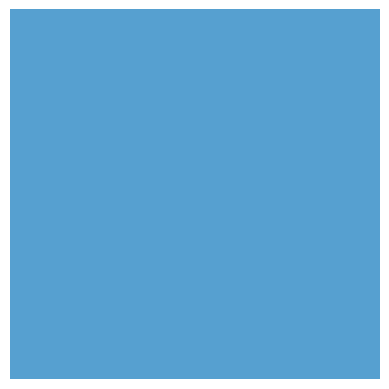

In [6]:
import matplotlib.pyplot as plt

# generate a square with the calculated color
def generateRGB_image(RGB):
    height, width, channel = 64, 64, 3
    arr = np.full((height, width, channel), [RGB[0], RGB[1], RGB[2]], dtype=('uint8'))
    plt.imshow(arr)
    plt.axis('off')

generateRGB_image(RGB)